# Modelling
## Load data necessary for modelling

In [1]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

# Load the CSVs
def load_and_display_data(file_name, name):
    data = pd.read_csv(file_name)
    print(f"{name} Data:")
    print(data.head(), "\n")
    return data

# Load the datasets
constructors = load_and_display_data('constructors.csv', 'Constructors')
drivers = load_and_display_data('drivers.csv', 'Drivers')
races = load_and_display_data('races.csv', 'Races')
results = load_and_display_data('results.csv', 'Results')

Constructors Data:
   constructorId constructorRef        name nationality  \
0              1        mclaren     McLaren     British   
1              2     bmw_sauber  BMW Sauber      German   
2              3       williams    Williams     British   
3              4        renault     Renault      French   
4              5     toro_rosso  Toro Rosso     Italian   

                                                 url  
0               http://en.wikipedia.org/wiki/McLaren  
1            http://en.wikipedia.org/wiki/BMW_Sauber  
2  http://en.wikipedia.org/wiki/Williams_Grand_Pr...  
3  http://en.wikipedia.org/wiki/Renault_in_Formul...  
4   http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso   

Drivers Data:
   driverId   driverRef number code  forename     surname         dob  \
0         1    hamilton     44  HAM     Lewis    Hamilton  1985-01-07   
1         2    heidfeld     \N  HEI      Nick    Heidfeld  1977-05-10   
2         3     rosberg      6  ROS      Nico     Rosberg  19

## Preprocessing
### Races
#### Extract only the relevant columns: raceid, year, round, circuitid

In [2]:
races = races[["raceId", "year", "round", "circuitId"]]

races.head()

,raceId,year,round,circuitId
0,1,2009,1,1
1,2,2009,2,2
2,3,2009,3,17
3,4,2009,4,3
4,5,2009,5,4


### Results
#### Extract only the relevant columns

In [3]:
results = results[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']]

results.head()

,raceId,driverId,constructorId,grid,positionOrder
0,18,1,1,1,1
1,18,2,2,5,2
2,18,3,3,7,3
3,18,4,4,11,4
4,18,5,1,3,5


### Merging results and races

In [5]:
df = pd.merge(races, results, on='raceId')

df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder
0,1,2009,1,1,18,23,1,1
1,1,2009,1,1,22,23,2,2
2,1,2009,1,1,15,7,20,3
3,1,2009,1,1,10,7,19,4
4,1,2009,1,1,4,4,10,5


### Creating a column for top 3

In [6]:
# Creating a column for Top 3 Finish
df['Top 3 Finish'] = (df['positionOrder'] <= 3).astype(int)

df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish
0,1,2009,1,1,18,23,1,1,1
1,1,2009,1,1,22,23,2,2,1
2,1,2009,1,1,15,7,20,3,1
3,1,2009,1,1,10,7,19,4,0
4,1,2009,1,1,4,4,10,5,0


## Feature engineering
### Top 3 finish % for each driver in each year

In [7]:
# Calculate total races, top 3 finishes, and top 3 finish percentage for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Top_3_Finishes=('Top 3 Finish', 'sum')
).assign(
    Driver_Top_3_Finish_Percentage_This_Year=lambda x: (x['Top_3_Finishes'] / x['Total_Races'] * 100)
).reset_index()

# Shift 'year' to create last year's stats
driver_yearly_stats['year'] += 1
driver_yearly_stats = driver_yearly_stats[['year', 'driverId', 'Driver_Top_3_Finish_Percentage_This_Year']].rename(
    columns={'Driver_Top_3_Finish_Percentage_This_Year': 'Driver Top 3 Finish Percentage (Last Year)'})

# Merge the last year's percentages into the original dataframe
df = pd.merge(df, driver_yearly_stats, on=['year', 'driverId'], how='left')

# Check the merged data
df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver Top 3 Finish Percentage (Last Year)
0,1,2009,1,1,18,23,1,1,1,0.000000
1,1,2009,1,1,22,23,2,2,1,5.555556
2,1,2009,1,1,15,7,20,3,1,5.555556
3,1,2009,1,1,10,7,19,4,0,5.555556
4,1,2009,1,1,4,4,10,5,0,16.666667


### Average of top 3 finish % for two driver in each constructor last year

In [8]:
# Calculate the mean of top 3 finish percentages for the two drivers in each constructor last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Constructor_Top_3_Finish_Percentage_Last_Year=('Driver Top 3 Finish Percentage (Last Year)', 'mean')
).reset_index()

# Merge the constructor stats back into the original dataframe
df = pd.merge(
    df, 
    constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor_Top_3_Finish_Percentage_Last_Year']], 
    on=['year', 'constructorId', 'round'], 
    how='left'
)

# Checking the merged data
df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver Top 3 Finish Percentage (Last Year),Constructor_Top_3_Finish_Percentage_Last_Year
0,1,2009,1,1,18,23,1,1,1,0.000000,2.777778
1,1,2009,1,1,22,23,2,2,1,5.555556,2.777778
2,1,2009,1,1,15,7,20,3,1,5.555556,5.555556
3,1,2009,1,1,10,7,19,4,0,5.555556,5.555556
4,1,2009,1,1,4,4,10,5,0,16.666667,11.111111


### Driver's average finishing position for the past year

In [9]:
# Calculate the total number of races and average position for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Driver_Avg_Position_This_Year=('positionOrder', 'mean')
).reset_index()

# Shift 'year' to create last year's stats and rename the column accordingly
driver_yearly_stats['year'] += 1
driver_yearly_stats = driver_yearly_stats[['year', 'driverId', 'Driver_Avg_Position_This_Year']].rename(
    columns={'Driver_Avg_Position_This_Year': 'Driver Avg position (Last Year)'})

# Merge the last year's average positions into the original dataframe
df = pd.merge(df, driver_yearly_stats, on=['year', 'driverId'], how='left')

# Check the merged data
df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver Top 3 Finish Percentage (Last Year),Constructor_Top_3_Finish_Percentage_Last_Year,Driver Avg position (Last Year)
0,1,2009,1,1,18,23,1,1,1,0.000000,2.777778,13.722222
1,1,2009,1,1,22,23,2,2,1,5.555556,2.777778,13.888889
2,1,2009,1,1,15,7,20,3,1,5.555556,5.555556,9.500000
3,1,2009,1,1,10,7,19,4,0,5.555556,5.555556,10.444444
4,1,2009,1,1,4,4,10,5,0,16.666667,11.111111,7.444444


### Constructor's average finishing position for the past year

In [10]:
# Calculate the average position for the two drivers in each constructor last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Constructor_Avg_Position_Last_Year=('Driver Avg position (Last Year)', 'mean')
).reset_index()

# Merge the constructor stats back into the original dataframe
df = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor_Avg_Position_Last_Year']],
              on=['year', 'constructorId', 'round'], how='left')

# Check the merged data
df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver Top 3 Finish Percentage (Last Year),Constructor_Top_3_Finish_Percentage_Last_Year,Driver Avg position (Last Year),Constructor_Avg_Position_Last_Year
0,1,2009,1,1,18,23,1,1,1,0.000000,2.777778,13.722222,13.805556
1,1,2009,1,1,22,23,2,2,1,5.555556,2.777778,13.888889,13.805556
2,1,2009,1,1,15,7,20,3,1,5.555556,5.555556,9.500000,9.972222
3,1,2009,1,1,10,7,19,4,0,5.555556,5.555556,10.444444,9.972222
4,1,2009,1,1,4,4,10,5,0,16.666667,11.111111,7.444444,10.250000


### Driver's average finishing position for current year till last race

In [11]:
def calculate_driver_avg_position_before_round(row):
    # Filter for previous races in the same year and same driver but in earlier rounds
    previous_races = df[(df['year'] == row['year']) & 
                        (df['driverId'] == row['driverId']) & 
                        (df['round'] < row['round'])]

    if previous_races.empty:
        return pd.NA

    # Calculate total races and sum of positions
    total_races = previous_races['raceId'].nunique()
    position_sum = previous_races['positionOrder'].sum()

    # Calculate and return average position
    return position_sum / total_races if total_races > 0 else pd.NA

# Apply the function to each row in the DataFrame
df['Driver Average Position (This Year till last race)'] = df.apply(calculate_driver_avg_position_before_round, axis=1)

df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver Top 3 Finish Percentage (Last Year),Constructor_Top_3_Finish_Percentage_Last_Year,Driver Avg position (Last Year),Constructor_Avg_Position_Last_Year,Driver Average Position (This Year till last race)
0,1,2009,1,1,18,23,1,1,1,0.000000,2.777778,13.722222,13.805556,<NA>
1,1,2009,1,1,22,23,2,2,1,5.555556,2.777778,13.888889,13.805556,<NA>
2,1,2009,1,1,15,7,20,3,1,5.555556,5.555556,9.500000,9.972222,<NA>
3,1,2009,1,1,10,7,19,4,0,5.555556,5.555556,10.444444,9.972222,<NA>
4,1,2009,1,1,4,4,10,5,0,16.666667,11.111111,7.444444,10.250000,<NA>


### Constructor's average finishing position for current year till last race

In [12]:
# Calculate the average position for the two drivers in each constructor this year
constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Constructor_Avg_Position_This_Year=('Driver Average Position (This Year till last race)', 'mean')
).reset_index()

# Merge the constructor stats back into the original dataframe
df = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor_Avg_Position_This_Year']],
              on=['year', 'constructorId', 'round'], how='left')

# Check the merged data
df.head()

,raceId,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver Top 3 Finish Percentage (Last Year),Constructor_Top_3_Finish_Percentage_Last_Year,Driver Avg position (Last Year),Constructor_Avg_Position_Last_Year,Driver Average Position (This Year till last race),Constructor_Avg_Position_This_Year
0,1,2009,1,1,18,23,1,1,1,0.000000,2.777778,13.722222,13.805556,<NA>,NaN
1,1,2009,1,1,22,23,2,2,1,5.555556,2.777778,13.888889,13.805556,<NA>,NaN
2,1,2009,1,1,15,7,20,3,1,5.555556,5.555556,9.500000,9.972222,<NA>,NaN
3,1,2009,1,1,10,7,19,4,0,5.555556,5.555556,10.444444,9.972222,<NA>,NaN
4,1,2009,1,1,4,4,10,5,0,16.666667,11.111111,7.444444,10.250000,<NA>,NaN


### We drop information related to the result of this race (e.g. finishing position) from the dataframe to prevent data leakage and also drop nans

In [13]:
df = df.drop(labels=["raceId"], axis=1)

# Drop rows with NaN values
df = df.dropna()

df.head()

,year,round,circuitId,driverId,constructorId,grid,positionOrder,Top 3 Finish,Driver Top 3 Finish Percentage (Last Year),Constructor_Top_3_Finish_Percentage_Last_Year,Driver Avg position (Last Year),Constructor_Avg_Position_Last_Year,Driver Average Position (This Year till last race),Constructor_Avg_Position_This_Year
20,2009,2,2,18,23,1,1,1,0.000000,2.777778,13.722222,13.805556,1.0,1.5
21,2009,2,2,2,2,10,2,1,22.222222,30.555556,6.500000,6.055556,10.0,12.0
22,2009,2,2,10,7,3,3,1,5.555556,5.555556,10.444444,9.972222,4.0,3.5
23,2009,2,2,15,7,2,4,0,5.555556,5.555556,9.500000,9.972222,3.0,3.5
24,2009,2,2,22,23,8,5,0,5.555556,2.777778,13.888889,13.805556,2.0,1.5


### Correlation matrix

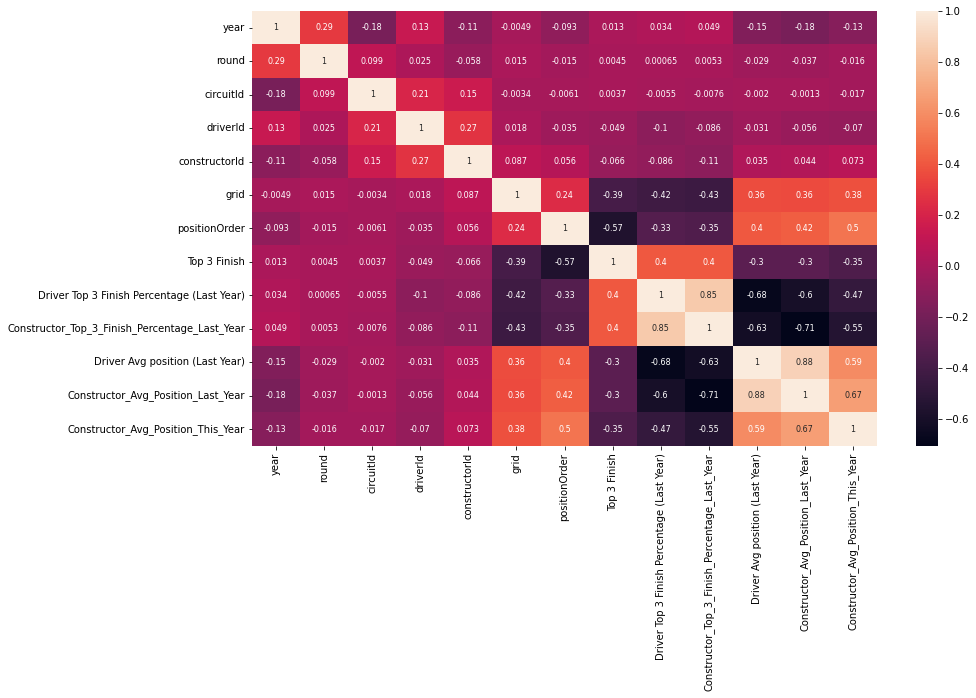

In [14]:
# heatmap
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), annot=True, annot_kws={"size": 8})
plt.show()

 ### One hot encoding

In [15]:
df = pd.get_dummies(df, columns=['circuitId', 'driverId', 'constructorId'])
df = df.drop(["positionOrder"], axis = 1)

# Create a list of columns excluding the one to move
cols = [col for col in df.columns if col != 'Top 3 Finish']

# Append the column to the end of the DataFrame
df = df[cols + ['Top 3 Finish']]

## Modelling
### Predicting F1 podiums

In [16]:
train_df = df[(df["year"] >= 1983) & (df["year"] <= 2009)]
val_df = df[(df["year"] >= 2010) & (df["year"] <= 2017)]
test_df = df[(df["year"] >= 2018) & (df["year"] <= 2024)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression


C:\Users\alanm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix for LogisticRegression:
[[1687  131]
 [ 139  246]]
Test AUC-ROC: 0.9202, Accuracy: 0.8774, Precision: 0.6525, Recall: 0.6390, F1-Score: 0.6457
Model: KNeighborsClassifier
Confusion Matrix for KNeighborsClassifier:
[[1629  189]
 [ 203  182]]
Test AUC-ROC: 0.8116, Accuracy: 0.8221, Precision: 0.4906, Recall: 0.4727, F1-Score: 0.4815
Model: RandomForestClassifier
Confusion Matrix for RandomForestClassifier:
[[1732   86]
 [ 200  185]]
Test AUC-ROC: 0.9148, Accuracy: 0.8702, Precision: 0.6827, Recall: 0.4805, F1-Score: 0.5640
Model: DecisionTreeClassifier
Confusion Matrix for DecisionTreeClassifier:
[[1674  144]
 [ 121  264]]
Test AUC-ROC: 0.8799, Accuracy: 0.8797, Precision: 0.6471, Recall: 0.6857, F1-Score: 0.6658
Model: StackedModel


C:\Users\alanm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\alanm\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Confusion Matrix for StackedModel:
[[1691  127]
 [ 138  247]]
Test AUC-ROC: 0.9125, Accuracy: 0.8797, Precision: 0.6604, Recall: 0.6416, F1-Score: 0.6509


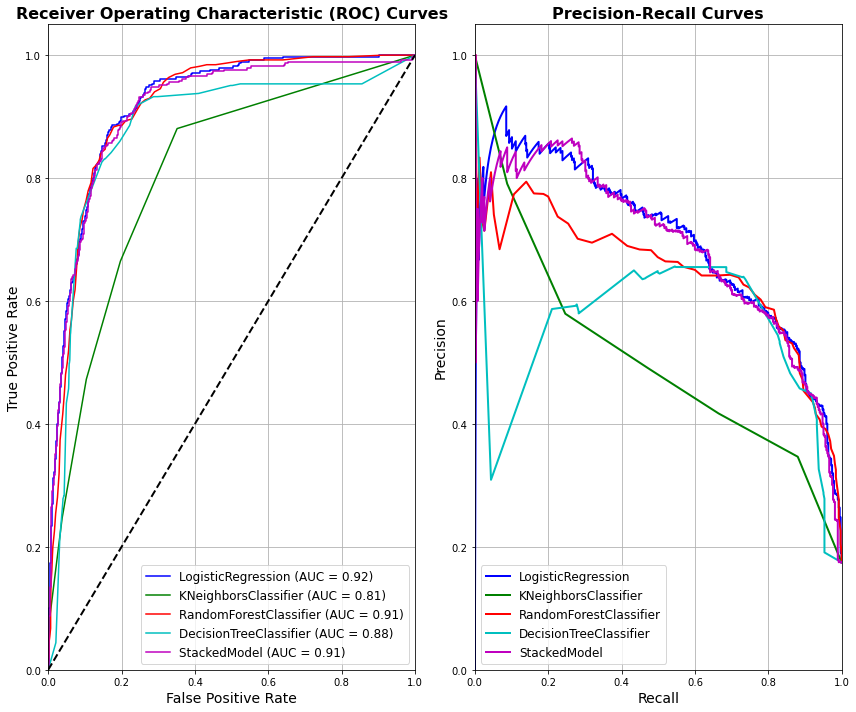

In [23]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Initialize base models for stacking
logistic_model = LogisticRegression(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5),
    'RandomForestClassifier': RandomForestClassifier(random_state=42, n_estimators=100),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42, max_depth=10),
    'StackedModel': StackingClassifier(
        estimators=[
            ('logistic', logistic_model), 
            ('random_forest', random_forest_model)
        ],
        final_estimator=LogisticRegression(random_state=42)  # Meta-model
    )
}

model_accuracy_info = {}

# Function to evaluate models
def evaluate_model(model, name, X_test, y_test):
    pred_test_proba = model.predict_proba(X_test)[:, 1]
    pred_test_class = (pred_test_proba >= 0.5).astype(int)

    # Calculate various evaluation metrics
    metrics = {
        'auc_roc': roc_auc_score(y_test, pred_test_proba),
        'accuracy': accuracy_score(y_test, pred_test_class),
        'precision': precision_score(y_test, pred_test_class),
        'recall': recall_score(y_test, pred_test_class),
        'f1_score': f1_score(y_test, pred_test_class),
        'confusion_matrix': confusion_matrix(y_test, pred_test_class)
    }

    # Print confusion matrix as part of model evaluation
    print(f"Confusion Matrix for {name}:\n{metrics['confusion_matrix']}")

    return metrics

# Train, evaluate, and save models
for name, model in models.items():
    print(f"Model: {name}")

    # Fit the model
    model.fit(X_train, y_train)

    # Evaluate the model on test data
    metrics = evaluate_model(model, name, X_test, y_test)

    print(f"Test AUC-ROC: {metrics['auc_roc']:.4f}, Accuracy: {metrics['accuracy']:.4f}, "
          f"Precision: {metrics['precision']:.4f}, Recall: {metrics['recall']:.4f}, F1-Score: {metrics['f1_score']:.4f}")

    # Save the model
    model_filename = f"{name}_model_V4.joblib"
    joblib.dump(model, model_filename)
    
    model_accuracy_info[name] = {'model': model_filename, **metrics}

# Plotting ROC and Precision-Recall Curves
plt.figure(figsize=(12, 10))  # Larger figure size
colors = ['b', 'g', 'r', 'c', 'm']  # Define distinct colors for each model
markers = ['o', 's', 'D', 'P', '*']  # Define markers for each model

# ROC Curve subplot
plt.subplot(1, 2, 1)
for i, (name, info) in enumerate(model_accuracy_info.items()):
    fpr, tpr, _ = roc_curve(y_test, models[name].predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, color=colors[i % len(colors)], label=f'{name} (AUC = {info["auc_roc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal dashed line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curves', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

# Precision-Recall Curve subplot
plt.subplot(1, 2, 2)
for i, (name, info) in enumerate(model_accuracy_info.items()):
    precision, recall, _ = precision_recall_curve(y_test, models[name].predict_proba(X_test)[:, 1])
    plt.plot(recall, precision, color=colors[i % len(colors)], label=f'{name}', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves', fontsize=16, fontweight='bold')
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)

plt.tight_layout()  # Adjust subplots for better layout
plt.show()
